In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.utils.vis_utils import plot_model

### Load dataset

In [17]:
train_dir = """ Add Path to train directory of dataset """
test_dir = """ Add Path to test directory of dataset """
model_path = """ Add Path to save models """


CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48

In [18]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 64 
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 10
input_shape = (48,48,3)
num_classes = len(CLASS_LABELS)

mlp_head_units = [2048, 1024, 256, 64]  # Size of the dense layers of the final classifier

In [20]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (image_size ,image_size),
                                                    batch_size = batch_size,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (image_size ,image_size),
                                                         batch_size = batch_size,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (image_size ,image_size),
                                                    batch_size = batch_size,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
!pip install --quiet vit-keras

### Pre-trained Vision transformer

In [21]:
from vit_keras import vit
vit_mpdel = vit.vit_b32(image_size = image_size, 
                       activation = 'softmax',
                       pretrained=True,
                       include_top=False,
                       pretrained_top=False,
                       classes=7)

Found 7178 images belonging to 7 classes.
1/1 [==============================] - 2s 2s/step


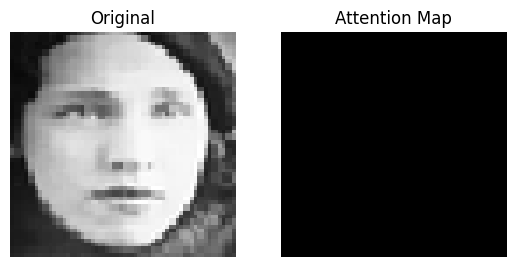

In [86]:
from vit_keras import visualize

img_datagen = ImageDataGenerator(rescale=1./255)
img_generator = img_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (image_size ,image_size),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
images, classes = next(img_generator)
image = images[5]

attention_map = visualize.attention_map(model = vit_mpdel, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [13]:
model = tf.keras.Sequential([
        vit_mpdel,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 7)          

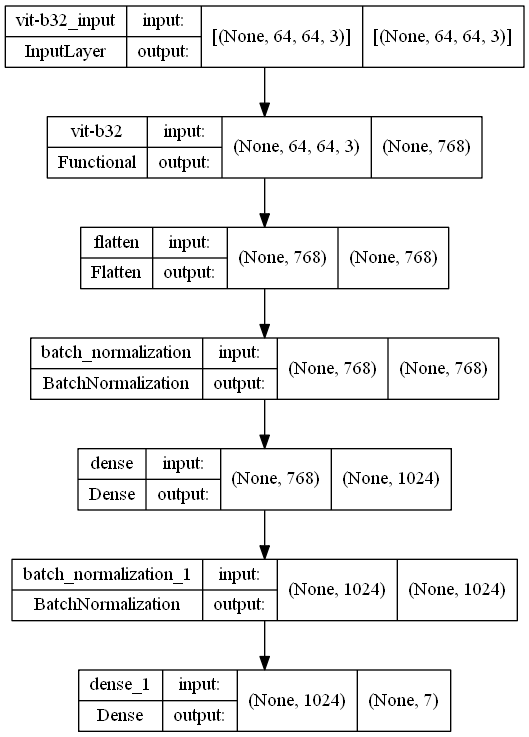

In [14]:
plot_model(model, to_file='ViT_plot.png', show_shapes=True, show_layer_names=True)

In [88]:
model.compile(optimizer = Adam(lr=1e-4), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
model.fit(x = train_generator,
          validation_data = validation_generator,
          epochs = EPOCHS)


Epoch 1/100
180/180 [==============================] - 43s 159ms/step - loss: 2.3260 - accuracy: 0.1663 - val_loss: 2.0864 - val_accuracy: 0.1653
Epoch 2/100
180/180 [==============================] - 26s 144ms/step - loss: 2.0229 - accuracy: 0.1988 - val_loss: 2.0398 - val_accuracy: 0.2428
Epoch 3/100
180/180 [==============================] - 26s 144ms/step - loss: 1.8828 - accuracy: 0.2252 - val_loss: 1.8265 - val_accuracy: 0.2672
Epoch 4/100
180/180 [==============================] - 27s 147ms/step - loss: 1.8212 - accuracy: 0.2501 - val_loss: 1.8193 - val_accuracy: 0.2648
Epoch 5/100
180/180 [==============================] - 26s 144ms/step - loss: 1.7888 - accuracy: 0.2721 - val_loss: 1.8838 - val_accuracy: 0.2874
Epoch 6/100
180/180 [==============================] - 26s 146ms/step - loss: 1.7722 - accuracy: 0.2819 - val_loss: 1.7559 - val_accuracy: 0.2881
Epoch 7/100
180/180 [==============================] - 26s 146ms/step - loss: 1.7405 - accuracy: 0.2962 - val_loss: 1.7592 -

KeyboardInterrupt: 

In [90]:
model.layers[1].trainable = True

model.compile(optimizer=Adam(lr=1e-4), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)

Epoch 1/20
180/180 [==============================] - 43s 162ms/step - loss: 1.5717 - accuracy: 0.3871 - val_loss: 1.6247 - val_accuracy: 0.3722
Epoch 2/20
180/180 [==============================] - 26s 144ms/step - loss: 1.5499 - accuracy: 0.3964 - val_loss: 1.5726 - val_accuracy: 0.3844
Epoch 3/20
180/180 [==============================] - 26s 144ms/step - loss: 1.5447 - accuracy: 0.3962 - val_loss: 1.5950 - val_accuracy: 0.3921
Epoch 4/20
180/180 [==============================] - 26s 145ms/step - loss: 1.5270 - accuracy: 0.4089 - val_loss: 1.5242 - val_accuracy: 0.4106
Epoch 5/20
180/180 [==============================] - 26s 145ms/step - loss: 1.5128 - accuracy: 0.4114 - val_loss: 1.5327 - val_accuracy: 0.4072
Epoch 6/20
180/180 [==============================] - 26s 145ms/step - loss: 1.4938 - accuracy: 0.4205 - val_loss: 1.5060 - val_accuracy: 0.4255
Epoch 7/20
180/180 [==============================] - 26s 145ms/step - loss: 1.4895 - accuracy: 0.4235 - val_loss: 1.5247 - val_ac

In [91]:
model.fit(x = train_generator,epochs = 80 ,validation_data = validation_generator)

Epoch 1/80
180/180 [==============================] - 26s 144ms/step - loss: 1.1889 - accuracy: 0.5521 - val_loss: 1.5318 - val_accuracy: 0.4450
Epoch 2/80
180/180 [==============================] - 26s 145ms/step - loss: 1.1574 - accuracy: 0.5645 - val_loss: 1.5156 - val_accuracy: 0.4677
Epoch 3/80
180/180 [==============================] - 26s 143ms/step - loss: 1.1295 - accuracy: 0.5764 - val_loss: 1.5971 - val_accuracy: 0.4578
Epoch 4/80
180/180 [==============================] - 26s 144ms/step - loss: 1.1024 - accuracy: 0.5899 - val_loss: 1.5639 - val_accuracy: 0.4632
Epoch 5/80
180/180 [==============================] - 26s 146ms/step - loss: 1.0737 - accuracy: 0.5973 - val_loss: 1.5894 - val_accuracy: 0.4471
Epoch 6/80
180/180 [==============================] - 27s 150ms/step - loss: 1.0369 - accuracy: 0.6127 - val_loss: 1.6197 - val_accuracy: 0.4679
Epoch 7/80
180/180 [==============================] - 26s 145ms/step - loss: 1.0050 - accuracy: 0.6258 - val_loss: 1.6514 - val_ac

In [92]:
import os
resultPath = """ Add Path to save models here """
file = "ViT_100Epochs.h5"
modelPath = os.path.join(resultPath, file)
model.save(modelPath)